<a href="https://colab.research.google.com/github/armelyara/plantes225/blob/master/drgreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is about Dr Green machine learning model for plant classification. We will use this model to build a mobile app which can give you the scientific name, local name, common name and therapeutic vertues.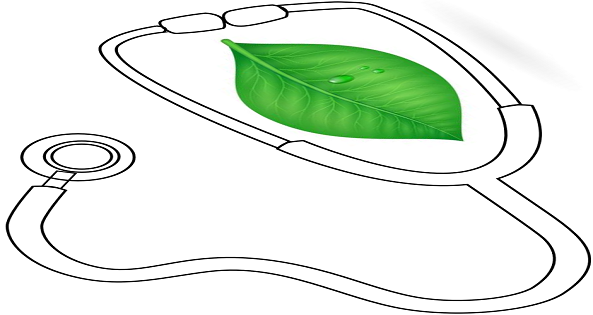

In [60]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version
except Exception:
  pass
import tensorflow as tf

import os 
import numpy as np
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt
import zipfile 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [61]:
print(tf.__version__)

2.9.2


In [62]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs={}):
    if(logs.get('loss')<0.4):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = MyCallback()


**DATA PROCESSING**

In [63]:
#Path to download dataset
local_zip = '/tmp/plantes.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/plantes')
zip_ref.close()

#Define the datasate path
base_dir = '/tmp/plantes/rename/'


In [64]:
#Count the total number of image in the dataset
image_count = len(list(glob.glob(base_dir + '*/*')))

print(image_count)

1118


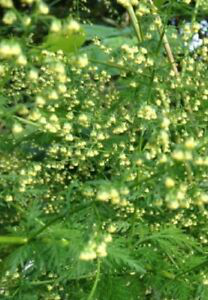

In [65]:
#Show any artemisia image
artemisia = list(glob.glob(base_dir + 'artemisia/*'))
PIL.Image.open(str(artemisia[1]))

In [87]:
#Parameters for the loader
batch_size = 64
img_height = 180
img_width = 180

In [88]:
#Split the dataset in training & validation set
train_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_pl = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1115 files belonging to 4 classes.
Using 892 files for training.
Found 1115 files belonging to 4 classes.
Using 223 files for validation.


In [68]:
#Find the class names using class_names attribut
class_names = train_pl.class_names
print(class_names)

['artemisia', 'carica', 'goyavier', 'kinkeliba']


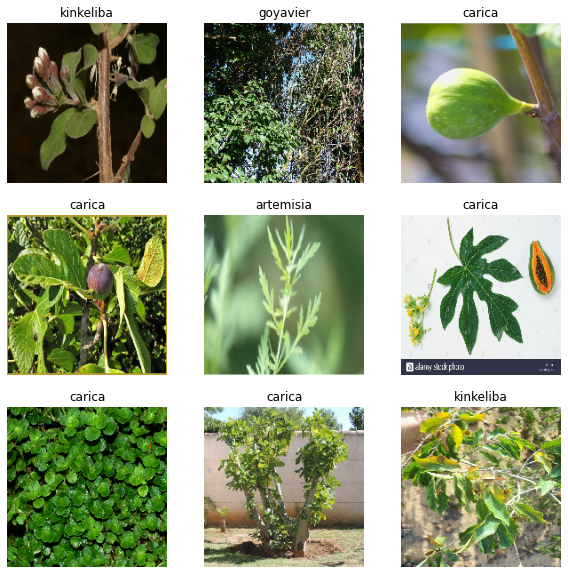

In [69]:
#Visualize the data. Here you will see the first nine images from the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_pl.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [89]:
#Iterate over the dataset and retrieve batches of images

for image_batch, labels_batch in train_pl:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [90]:
#Overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_pl = train_pl.cache().prefetch(buffer_size=AUTOTUNE)
val_pl = val_pl.cache().prefetch(buffer_size=AUTOTUNE)

In [91]:
#Standardize Data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [92]:
normalized_ds = train_pl.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [93]:
#We will use Data augmentation to avoid overfitting because we have small data in training set
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

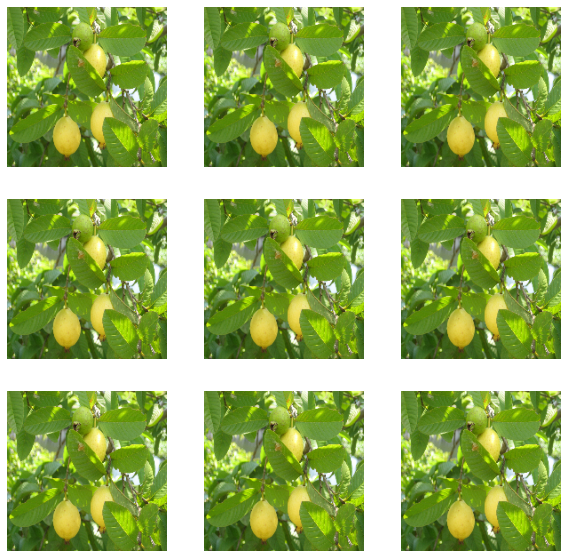

In [94]:
#Visualizing a few augmented image 
plt.figure(figsize=(10, 10))
for images, _ in train_pl.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Build a sequential model with Keras API. 

In [95]:
#Build our sequantial model using Dropout which are a technique to reduce overfitting 
num_classes = 4

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, name="outputs")
])

In [96]:
#Compile our model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [97]:
#Show model parameters
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

In [98]:
#Train our model
epochs = 50
history = model.fit(
  train_pl,
  validation_data=val_pl,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/50
14/14 [==============================] - 41s 3s/step - loss: 1.6675 - accuracy: 0.2545 - val_loss: 1.3581 - val_accuracy: 0.3677
Epoch 2/50
14/14 [==============================] - 32s 2s/step - loss: 1.3831 - accuracy: 0.2926 - val_loss: 1.3630 - val_accuracy: 0.3677
Epoch 3/50
14/14 [==============================] - 35s 3s/step - loss: 1.3565 - accuracy: 0.3217 - val_loss: 1.3601 - val_accuracy: 0.3722
Epoch 4/50
14/14 [==============================] - 32s 2s/step - loss: 1.3427 - accuracy: 0.3599 - val_loss: 1.3358 - val_accuracy: 0.4126
Epoch 5/50
14/14 [==============================] - 32s 2s/step - loss: 1.3152 - accuracy: 0.3823 - val_loss: 1.3299 - val_accuracy: 0.3498
Epoch 6/50
14/14 [==============================] - 32s 2s/step - loss: 1.2728 - accuracy: 0.4126 - val_loss: 1.3097 - val_accuracy: 0.3812
Epoch 7/50
14/14 [==============================] - 32s 2s/step - loss: 1.2510 - accuracy: 0.4395 - val_loss: 1.2889 - val_accuracy: 0.3901
Epoch 8/50
14/14 [==

ValueError: ignored

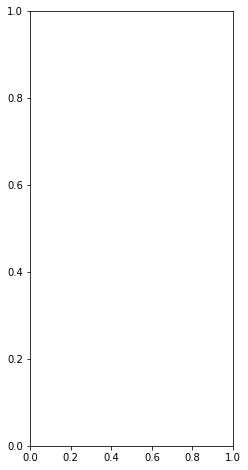

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
#Test our model with another image unseen in training and validation set
import numpy as np

from google.colab import files
from keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img= load_img(path, target_size=(180, 180))
  
  x=img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  plantes = model.predict(images, batch_size=32)
  
  print(plantes[0])
  
  if plantes.any():
    print(fn + "is an artemisia")
    
  else:
    print(fn + "is a carica")
 

KeyboardInterrupt: ignored

In [ ]:
#Convert and save model in TensorFlow Lite
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('drgreen.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#Download model 
from google.colab import files

files.download('drgreen.tflite')
files.download('plants.txt')